In [1]:
import uproot
import awkward as ak #The events object is an awkward array
## Plotting.
import matplotlib.pyplot as plt

# Hists
import hist
from hist import Hist

# NanoEvents
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# Processors (for parallelization)
#import coffea.processor as processor
from coffea import processor

#Math
import math

#Numpy
import numpy as np

#PackedSelection to select events
from coffea.analysis_tools import PackedSelection

#Clock to count time
import time

In [2]:
# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        pass
    
    def process(self, old_events):
        #Implement the selections to veto events
        selection = PackedSelection()
        #At least one lepton 
        selection.add("one_l", (ak.num(old_events.Electron)+ak.num(old_events.Muon))>=1)
        #Electron signal region
        selection.add("fst_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) >= 1)[:, 0].mvaFall17V2Iso_WP90 == True)
        selection.add(
            "electron_pT",
            ak.any(old_events.Electron.pt > 35.0, axis=1)  
        )
        selection.add(
            "e_range_eta",
            ak.any(abs (old_events.Electron.eta) < 2.5, axis=1)
        )
        #The following two cuts work in inverse logic, when you require the selection later you must take false
        selection.add("snd_tight_e", ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WP90 == True)
        selection.add("loose_e", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == True) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
        #Muon signal region (boosted)
        selection.add("one_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) >= 1)[:, 0].tightId == (3>2))
        selection.add("no_2nd_tight_mu", ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].tightId == (3==2))
        #The following three cuts work in inverse logic, when you require the selection later you must take false
        selection.add("any_tight_e", ak.any(old_events.Electron.mvaFall17V2Iso_WP90 == (3>2), axis=1))
        selection.add(
            "muon_pT",
            ak.any(old_events.Muon.pt >= 30.0, axis=1)
        )
        selection.add(
            "mu_range_eta",
            ak.any(abs (old_events.Muon.eta) < 2.4, axis=1)
        )
        selection.add("loose_mu", (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].looseId == (3>2)) & (ak.mask(old_events.Muon, ak.num(old_events.Muon) > 1)[:, 1].pt >10))
        selection.add("loose_e1", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].mvaFall17V2Iso_WPL == (3>2)) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 0].pt >10))
        selection.add("loose_e2", (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].mvaFall17V2Iso_WPL == (3>2)) & (ak.mask(old_events.Electron, ak.num(old_events.Electron) > 1)[:, 1].pt >10))
        #Puppy met cut
        selection.add("lead_pMET", old_events.PuppiMET.pt>30)
        #b Veto
        selection.add("b_veto", ak.all(old_events.Jet.btagDeepB<=0.84, axis=1))
        #selection.add("b_veto", ak.all(old_events.Jet.btagCSVV2<=0.81, axis=1))
        #VBS jets (looking for the max invariant mass pair)
        # Get all combinations of jet pairs in every event
        dijets_o = ak.combinations(old_events.Jet, 2, fields=['i0', 'i1'])
        # Check that jet pairs have the greatest mass
        ismax_o=(dijets_o['i0']+dijets_o['i1']).mass==ak.max((dijets_o['i0']+dijets_o['i1']).mass, axis=1)
        #previous line: returns a Boolean array with True where the condition is met, and false otherwise
        # Mask the dijets with the ismax to get dijets with the gratest mass
        VBS_jets_o = dijets_o[ismax_o]
        # Separate pairs into arrays of the leading and the trailing VBS jets in each pair.
        VBS_ljet_o, VBS_tjet_o = ak.unzip(VBS_jets_o)
        #VBS selection
        selection.add(
            "lead_VBS_ljet",   
            ak.all(VBS_ljet_o.pt>50, axis=1)
        )
        selection.add(
            "lead_VBS_tjet",   
            ak.all(VBS_tjet_o.pt>30, axis=1)
        )
        selection.add(
            "lead_VBS_mass",   
            ak.all((VBS_ljet_o+VBS_tjet_o).mass>500, axis=1)
        )
        selection.add(
            "lead_VBS_eta",   
            ak.all(abs(VBS_ljet_o.eta-VBS_tjet_o.eta)>2.5, axis=1)
        )
        selection.add("one_fatjet", (ak.num(old_events.FatJet) == 1))
        selection.add("two_jet", (ak.num(old_events.Jet) >= 2))
        #Transverse mass of the W boson decaying leptonically
        #With electrons
        selection.add(
            "W_Tmass_e",
            ak.all(2*old_events.Electron.pt*old_events.MET.pt*(1-np.cos(old_events.Electron.phi-old_events.MET.phi))<185**2, axis=1)
        )
        #With muons
        selection.add(
            "W_Tmass_mu",
            ak.all(2*old_events.Muon.pt*old_events.MET.pt*(1-np.cos(old_events.Muon.phi-old_events.MET.phi))<185**2, axis=1)
        )
        #Invariant mass of the W boson decaying hadronically, use softdropmass
        selection.add(
            "W_mass_fatjet",
            ak.all((old_events.FatJet.msoftdrop>70) & (old_events.FatJet.msoftdrop<115), axis=1)
        )
        #Electron mask
        #one_l=True, fst_tight_e=True, snd_tight_e=False, loose_e=False, electron_pT=True, e_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_e=True, W_mass_fatjet=True
        ev_mask_e = selection.require(one_l=True, fst_tight_e=True, snd_tight_e=False, loose_e=False, electron_pT=True, e_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, two_jet=True, one_fatjet=True, W_mass_fatjet=True)
        #Muon mask
        ev_mask_mu = selection.require(one_l=True, one_tight_mu=True, no_2nd_tight_mu=True, loose_mu=False, loose_e1=False, loose_e2=False, any_tight_e=False, muon_pT=True, mu_range_eta=True, lead_pMET=True, b_veto=True, lead_VBS_ljet=True, lead_VBS_tjet=True, lead_VBS_mass=True, lead_VBS_eta=True, one_fatjet=True, two_jet=True, W_Tmass_mu=True, W_mass_fatjet=True)
        #Apply the cuts on the events with the mask (chose either electron or muon signal region)
        events=old_events[ev_mask_e]
        
        # This is where we do our actual analysis. The dataset has columns similar to the TTree's; events.columns can tell you them, or events.[object].columns for deeper depth.
        dataset = events.metadata['dataset']
        #Define the fiducial region
        #Electron, muon , jets, fatjets
        jets=events.Jet
        fatjets = events.FatJet
        #Jets isolation from electrons
        # Get all combinations of jets and electrons in every event
        jets_e = ak.cartesian({"x": jets, "y": events.Electron})
        # Check that jets satisfy the isolation
        jets_iso_e = ((jets_e["x"].eta-jets_e["y"].eta)**2+(jets_e["x"].phi-jets_e["y"].phi)**2>0.4**2)
        # Mask the jets_e with the jets_iso to get jets isolated from electrons
        jets_e = jets_e[jets_iso_e]
        # Separate pairs into jets and electons, redefining the jets (but not the electrons)
        jets, el = ak.unzip(jets_e)
        #FatJets isolation from electrons
        # Get all combinations of fatjets and electrons in every event
        fatjets_e = ak.cartesian({"x": fatjets, "y": events.Electron})
        # Check that jets satisfy the isolation
        fatjets_iso_e = ((fatjets_e["x"].eta-fatjets_e["y"].eta)**2+(fatjets_e["x"].phi-fatjets_e["y"].phi)**2>0.8**2)
        # Mask the fatjets_e with the fatjets_iso to get fatjets isolated from electrons
        fatjets_e = fatjets_e[fatjets_iso_e]
        # Separate pairs into fatjets and electons, redefining the fatjets (but not the electrons)
        fatjets, el = ak.unzip(fatjets_e)
        #Jets isolation from muons
        # Get all combinations of jets and muons in every event
        #jets_mu = ak.cartesian({"x": jets, "y": events.Muon})
        # Check that jets satisfy the isolation
        #jets_iso_mu = ((jets_mu["x"].eta-jets_mu["y"].eta)**2+(jets_mu["x"].phi-jets_mu["y"].phi)**2>0.4**2)
        # Mask the jets_mu with the jets_iso_mu to get jets isolated from muons
        #jets_mu = jets_mu[jets_iso_mu]
        # Separate pairs into jets and muons, redefining the jets (but not the muons)
        #jets, mu = ak.unzip(jets_mu)
        #FatJets isolation from muons
        # Get all combinations of fatjets and muons in every event
        #fatjets_mu = ak.cartesian({"x": fatjets, "y": events.Muon})
        # Check that fatjets satisfy the isolation
        #fatjets_iso_mu = ((fatjets_mu["x"].eta-fatjets_mu["y"].eta)**2+(fatjets_mu["x"].phi-fatjets_mu["y"].phi)**2>0.8**2)
        # Mask the fatjets_mu with the fatjets_iso_mu to get fatjets isolated from muons
        #fatjets_mu = fatjets_mu[fatjets_iso_mu]
        # Separate pairs into jets and muons, redefining the jets (but not the muons)
        #fatjets, mu = ak.unzip(fatjets_mu)
        #Jets cuts
        jets_eta_cut = (abs (jets.eta) < 4.7)
        jets_pT_cut = (jets.pt > 30)
        jets = jets[jets_pT_cut&jets_eta_cut]
        #FatJets cuts
        fatjets_eta_cut = (abs (fatjets.eta) < 2.4)
        fatjets_pT_cut = (fatjets.pt > 200)
        fatjets = fatjets[fatjets_pT_cut&fatjets_eta_cut]
        #Removing AK4(Jet) jets overlapping with AK8(FatJets) jets
        # Get all combinations of jets and fatjets in every event
        jets_fatjets = ak.cartesian({"x": jets, "y": fatjets})
        # Check that jets satisfy the isolation
        jets_iso_f = ((jets_fatjets["x"].eta-jets_fatjets["y"].eta)**2+(jets_fatjets["x"].phi-jets_fatjets["y"].phi)**2>0.8**2)
        # Mask the jets_fatjets with the jets_iso_f to get jets isolated from fatjets
        jets_fatjets = jets_fatjets[jets_iso_f]
        # Separate pairs into jets and electons, redefining the jets (but not the fatjets)
        jets, fj = ak.unzip(jets_fatjets)
        #VBS jets (looking for the max invariant mass pair)
        # Get all combinations of jet pairs in every event
        VBSjets = ak.combinations(events.Jet, 2, fields=['i0', 'i1'])
        # Mask the dijets with the ismax to get dijets with the gratest mass
        VBS_jets = VBSjets[(VBSjets['i0']+VBSjets['i1']).mass==ak.max((VBSjets['i0']+VBSjets['i1']).mass, axis=1)]
        # Separate pairs into arrays of the leading and the trailing VBS jets in each pair.
        VBS_jet_lead, VBS_jet_trail = ak.unzip(VBS_jets)
        
        #Get the variables of N-subjectiness
        tau_1=fatjets.tau1
        tau_2=fatjets.tau2
        #Take the tau2 to tau1 ratio
        tau_r=tau_2/tau_1
        #Get the variables of particleNet and deepTag
        pNet=fatjets.particleNet_WvsQCD
        dTag=fatjets.deepTag_WvsQCD
        
        # Bins and categories for the histogram
        h_PuppiMET = hist.Hist(hist.axis.StrCategory(name='channel', categories=['PuppiMET']), 
                      hist.axis.Regular(name='x', label='PuppiMET [GeV]', bins=30, start=30, stop=300))
        h_e_pT = hist.Hist(hist.axis.StrCategory(name='channel', categories=['e_pT']), 
                      hist.axis.Regular(name='x', label='$p_{T}^{e}$ [GeV]', bins=20, start=35, stop=200))
        h_e_eta = hist.Hist(hist.axis.StrCategory(name='channel', categories=['e_eta']), 
                      hist.axis.Regular(name='x', label='$\eta^{e}$', bins=30, start=-2.5, stop=2.5))
        h_fatjet_pT = hist.Hist(hist.axis.StrCategory(name='channel', categories=['fatjet_pT']), 
                      hist.axis.Regular(name='x', label='$p_{T}^{W_{had}}$ [GeV]', bins=20, start=200, stop=600))
        h_fatjet_mass = hist.Hist(hist.axis.StrCategory(name='channel', categories=['fatjet_mass']), 
                      hist.axis.Regular(name='x', label='$m^{W_{had}}$ [GeV]', bins=20, start=30, stop=150))
        h_jets_mass = hist.Hist(hist.axis.StrCategory(name='channel', categories=['jets_mass']), 
                      hist.axis.Regular(name='x', label='$m_{jj} VBS$ [GeV]', bins=24, start=500, stop=3500))
        h_jets_eta = hist.Hist(hist.axis.StrCategory(name='channel', categories=['jets_eta']), 
                      hist.axis.Regular(name='x', label='$\Delta\eta_{jj} VBS$', bins=20, start=2.5, stop=8.5))
        h_jets_lead = hist.Hist(hist.axis.StrCategory(name='channel', categories=['jets_lead']), 
                      hist.axis.Regular(name='x', label='$leading VBS p_{T}^{j}$ [Gev]', bins=20, start=50, stop=500))
        h_jets_trail = hist.Hist(hist.axis.StrCategory(name='channel', categories=['jets_trail']), 
                      hist.axis.Regular(name='x', label='$trailing VBS p_{T}^{j}$ [Gev]', bins=14, start=30, stop=250))
        h_LHE_HT = hist.Hist(hist.axis.StrCategory(name='channel', categories=['LHE_HT']), 
                      hist.axis.Variable([70,100,200,400,600,800,1200,2500,3500],name='x', label='LHE HT'))
        h_Nsubj_t1 = hist.Hist(hist.axis.StrCategory(name='channel', categories=['$t_{1}$']), 
                      hist.axis.Regular(name='x', label='tau_1', bins=40, start= 0, stop=1))
        h_Nsubj_t2 = hist.Hist(hist.axis.StrCategory(name='channel', categories=['$t_{2}$']), 
                      hist.axis.Regular(name='x', label='tau_2', bins=40, start= 0, stop=1))
        h_t_ratio = hist.Hist(hist.axis.StrCategory(name='channel', categories=['t_ratio']), 
                      hist.axis.Regular(name='x', label='tau_r', bins=40, start= 0, stop=1))
        h_pNet = hist.Hist(hist.axis.StrCategory(name='channel', categories=['pNet']), 
                      hist.axis.Regular(name='x', label='WvsQCD', bins=40, start= 0, stop=1))

        
             
        # This fills our histogram once our data is collected.
        h_PuppiMET.fill(channel='PuppiMET', x=events.PuppiMET.pt)
        h_e_pT.fill(channel='e_pT', x=events.Electron[:,0].pt)
        h_e_eta.fill(channel='e_eta', x=events.Electron[:,0].eta)
        h_fatjet_pT.fill(channel='fatjet_pT', x=ak.flatten(fatjets.pt))
        h_fatjet_mass.fill(channel='fatjet_mass', x=ak.flatten(fatjets.mass))
        #previous line: you have to flatten the awkward array because its size is ambiguous due to variable-length arrays
        h_jets_mass.fill(channel='jets_mass', x=ak.flatten((VBS_jet_lead+VBS_jet_trail).mass))
        h_jets_eta.fill(channel='jets_eta', x=ak.flatten(abs(VBS_jet_lead.eta-VBS_jet_trail.eta)))
        h_jets_lead.fill(channel='jets_lead', x=ak.flatten(VBS_jet_lead.pt))
        h_jets_trail.fill(channel='jets_trail', x=ak.flatten(VBS_jet_trail.pt))
        h_LHE_HT.fill(channel='LHE_HT', x=events.LHE.HT)
        h_Nsubj_t1.fill(channel='$t_{1}$', x=ak.flatten(tau_1))
        h_Nsubj_t2.fill(channel='$t_{2}$', x=ak.flatten(tau_2))
        h_t_ratio.fill(channel='t_ratio', x=ak.flatten(tau_r))
        h_pNet.fill(channel='pNet', x=ak.flatten(pNet))
        
        return {
            dataset: {
                "entries": len(events),
                "PuppiMET": h_PuppiMET,
                "e_pT": h_e_pT,
                "e_eta": h_e_eta,
                "fatjet_pT": h_fatjet_pT,
                "fatjet_mass": h_fatjet_mass,
                "jets_mass": h_jets_mass,
                "jets_eta": h_jets_eta,
                "jets_lead": h_jets_lead,
                "jets_trail": h_jets_trail,
                "LHE_HT": h_LHE_HT,
                "Nsubj_t1": h_Nsubj_t1,
                "Nsubj_t2": h_Nsubj_t2,
                "t_ratio": h_t_ratio,
                "pNet": h_pNet
            }
        }
    
    def postprocess(self, accumulator):
        #This is where we can make post-analysis adjustments, such as handle weights, rebinning or scaling our histograms.
        pass

In [3]:
lumi_2018 = 59.74 #fb-1

xs_sig_WPHADWMLEPjj_4f_EWK = 0.9107
xs_sig_WPLEPWMHADjj_4f_EWK = 0.9114
xs_sig = xs_sig_WPHADWMLEPjj_4f_EWK + xs_sig_WPLEPWMHADjj_4f_EWK

xs_WJets = 61526.7 #pb
xs_WJets_70To100 = 1292.0
xs_WJets_100To200 = 1395.0
xs_WJets_200To400 = 407.9
xs_WJets_400To600 = 57.48
xs_WJets_600To800 = 18.77
xs_WJets_800To1200 = 5.366
xs_WJets_1200To2500 = 1.074
xs_WJets_2500ToInf = 0.008001

In [4]:
#Clock
tstart = time.time()

#The processor to run the executor to use
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=4),
    #In the previous line, we can then set the the number of cores to use as argument of the FuturesExecutor 
    schema=NanoAODSchema,
    #Coffea will split your data into chunks of many events.
    #chunksize=200_000 #default 100_000
    #maxchunks argument will stop the analysis after a certain number of chunks are reached
    #maxchunks=10,
)

out = futures_run(
    "fileset.json",
    "Events", #Name of the TTree in the root file
    processor_instance=MyProcessor()
)

elapsed = time.time() - tstart
print(elapsed)
print(out)

Preprocessing:   0%|          | 0/643 [00:00<?, ?file/s]

Processing:   0%|          | 0/3241 [00:00<?, ?chunk/s]

9709.334687232971
{'bkg_WJets_2500ToInf': {'fatjet_mass': Hist(
  StrCategory(['fatjet_mass'], name='channel'),
  Regular(20, 30, 150, name='x', label='$m^{W_{had}}$ [GeV]'),
  storage=Double()) # Sum: 2.0 (3.0 with flow), 'jets_mass': Hist(
  StrCategory(['jets_mass'], name='channel'),
  Regular(24, 500, 3500, name='x', label='$m_{jj} VBS$ [GeV]'),
  storage=Double()) # Sum: 2.0, 'jets_eta': Hist(
  StrCategory(['jets_eta'], name='channel'),
  Regular(20, 2.5, 8.5, name='x', label='$\\Delta\\eta_{jj} VBS$'),
  storage=Double()) # Sum: 2.0, 'PuppiMET': Hist(
  StrCategory(['PuppiMET'], name='channel'),
  Regular(30, 30, 300, name='x', label='PuppiMET [GeV]'),
  storage=Double()) # Sum: 0.0 (2.0 with flow), 'e_pT': Hist(
  StrCategory(['e_pT'], name='channel'),
  Regular(20, 35, 400, name='x', label='$p_{T}^{e}$ [GeV]'),
  storage=Double()) # Sum: 2.0, 'e_eta': Hist(
  StrCategory(['e_eta'], name='channel'),
  Regular(30, -2.5, 2.5, name='x', label='$\\eta^{e}$'),
  storage=Double()) # 

3630


Text(0.5, 1.0, 'PuppiMET distribution')

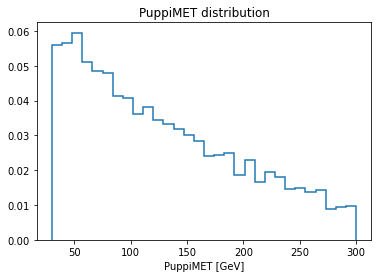

In [68]:
print(out["sig_WWjj_4f_EWK"]["entries"])
(out["sig_WWjj_4f_EWK"]["PuppiMET"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("PuppiMET [GeV]")
#plt.ylabel("counts")
plt.title("PuppiMET distribution")

Text(0.5, 1.0, 'electron $p_{T}$ distribution')

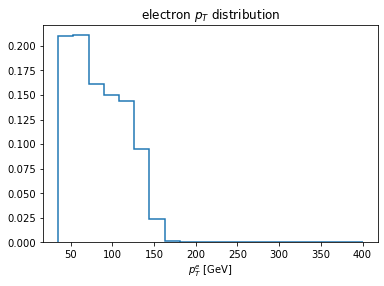

In [69]:
(out["sig_WWjj_4f_EWK"]["e_pT"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("$p_{T}^{e}$ [GeV]")
#plt.ylabel("counts")
plt.title("electron $p_{T}$ distribution")

Text(0.5, 1.0, 'electron $\\eta$ distribution')

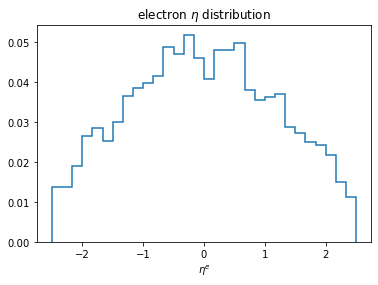

In [70]:
(out["sig_WWjj_4f_EWK"]["e_eta"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
#plt.ylabel("counts")
plt.title("electron $\eta$ distribution")

Text(0.5, 1.0, 'AK8 jet distribution')

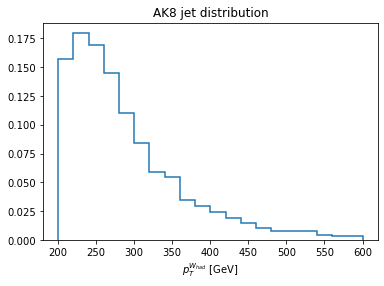

In [71]:
(out["sig_WWjj_4f_EWK"]["fatjet_pT"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("$p_{T}^{W_{had}}$ [GeV]")
#plt.ylabel("counts")
plt.title("AK8 jet distribution")

Text(0.5, 1.0, 'AK8 jet distribution')

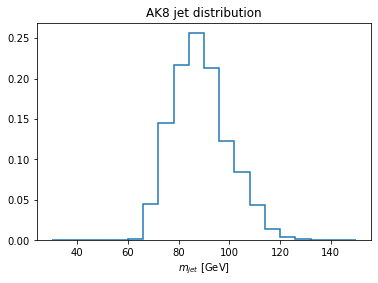

In [72]:
(out["sig_WWjj_4f_EWK"]["fatjet_mass"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("$m_{jet}$ [GeV]")
#plt.ylabel("counts")
plt.title("AK8 jet distribution")

Text(0.5, 1.0, 'VBS $m_{jj}$ distribution')

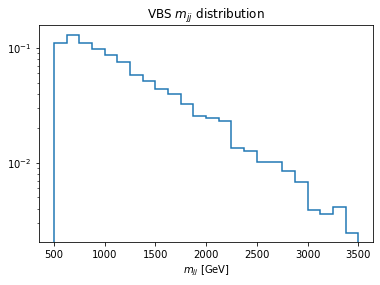

In [73]:
(out["sig_WWjj_4f_EWK"]["jets_mass"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("$m_{jj}$ [GeV]")
#plt.ylabel("counts")
plt.yscale("log")
plt.title("VBS $m_{jj}$ distribution")

Text(0.5, 1.0, '$\\Delta\\eta$ VBS jets')

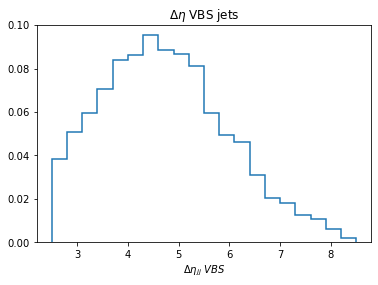

In [74]:
(out["sig_WWjj_4f_EWK"]["jets_eta"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("$\Delta\eta_{jj} \ VBS$")
#plt.ylabel("counts")
plt.title("$\Delta\eta$ VBS jets")

Text(0.5, 1.0, 'Leading VBS jet $p_{T}$')

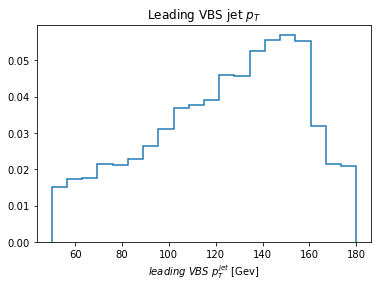

In [75]:
(out["sig_WWjj_4f_EWK"]["jets_lead"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("$leading \ VBS \ p_{T}^{jet}$ [Gev]")
#plt.ylabel("counts")
plt.title("Leading VBS jet $p_{T}$")

Text(0.5, 1.0, 'Trailing VBS jet $p_{T}$')

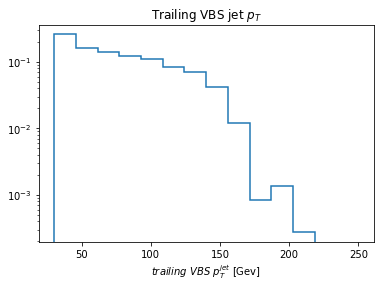

In [76]:
(out["sig_WWjj_4f_EWK"]["jets_trail"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
plt.xlabel("$trailing \ VBS \ p_{T}^{jet}$ [Gev]")
#plt.ylabel("counts")
plt.yscale("log")
plt.title("Trailing VBS jet $p_{T}$")

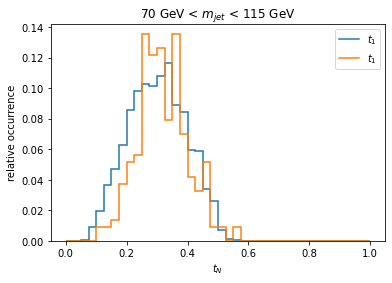

In [38]:
(out["sig_WWjj_4f_EWK"]["Nsubj_t1"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
(out["bkg_WJets"]["Nsubj_t1"]/out["bkg_WJets"]["entries"]).plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("$t_{N}$")
plt.ylabel("relative occurrence")
plt.legend()

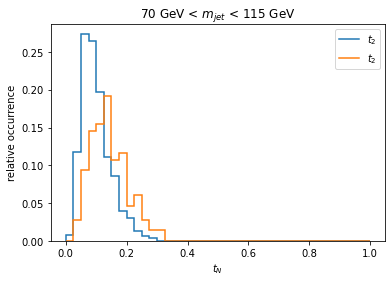

In [39]:
(out["sig_WWjj_4f_EWK"]["Nsubj_t2"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
(out["bkg_WJets"]["Nsubj_t2"]/out["bkg_WJets"]["entries"]).plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("$t_{N}$")
plt.ylabel("relative occurrence")
plt.legend()

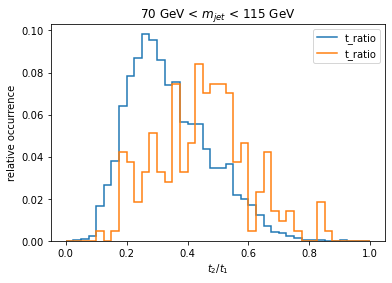

In [88]:
(out["sig_WWjj_4f_EWK"]["t_ratio"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
(out["bkg_WJets"]["t_ratio"]/out["bkg_WJets"]["entries"]).plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("$t_{2}/t_{1}$")
plt.ylabel("relative occurrence")
plt.legend()

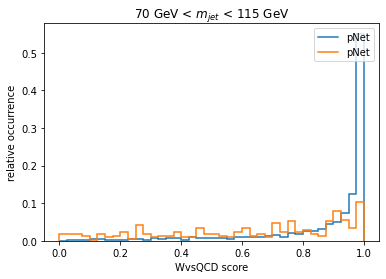

In [91]:
(out["sig_WWjj_4f_EWK"]["pNet"]/out["sig_WWjj_4f_EWK"]["entries"]).plot()
(out["bkg_WJets"]["pNet"]/out["bkg_WJets"]["entries"]).plot()
#(out["bkg_WJets"]["pNet"]/out["bkg_WJets"]["entries"]).plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("WvsQCD score")
plt.ylabel("relative occurrence")
plt.legend()

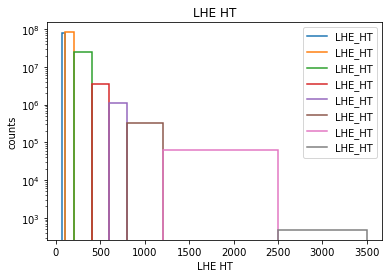

In [44]:
#(out["bkg_WJets"]["LHE_HT"]*lumi_2018*1000*xs_WJets/out["bkg_WJets"]["entries"]).plot()
h_1 = out["bkg_WJets_70To100"]["LHE_HT"]*lumi_2018*1000*xs_WJets_70To100/out["bkg_WJets_70To100"]["entries"]
h_2 = out["bkg_WJets_100To200"]["LHE_HT"]*lumi_2018*1000*xs_WJets_100To200/out["bkg_WJets_100To200"]["entries"]
h_3 = out["bkg_WJets_200To400"]["LHE_HT"]*lumi_2018*1000*xs_WJets_200To400/out["bkg_WJets_200To400"]["entries"]
h_4 = out["bkg_WJets_400To600"]["LHE_HT"]*lumi_2018*1000*xs_WJets_400To600/out["bkg_WJets_400To600"]["entries"]
h_5 = out["bkg_WJets_600To800"]["LHE_HT"]*lumi_2018*1000*xs_WJets_600To800/out["bkg_WJets_600To800"]["entries"]
h_6 = out["bkg_WJets_800To1200"]["LHE_HT"]*lumi_2018*1000*xs_WJets_800To1200/out["bkg_WJets_800To1200"]["entries"]
h_7 = out["bkg_WJets_1200To2500"]["LHE_HT"]*lumi_2018*1000*xs_WJets_1200To2500/out["bkg_WJets_1200To2500"]["entries"]
h_8 = out["bkg_WJets_2500ToInf"]["LHE_HT"]*lumi_2018*1000*xs_WJets_2500ToInf/out["bkg_WJets_2500ToInf"]["entries"]
h_1.plot(), h_2.plot(), h_3.plot(), h_4.plot(), h_5.plot(), h_6.plot(), h_7.plot(), h_8.plot()
plt.title("LHE HT")
plt.xlabel("LHE HT")
plt.yscale("log")
plt.ylabel("counts")
plt.legend()

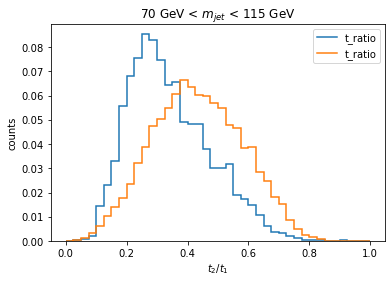

In [89]:
(out["sig_WWjj_4f_EWK"]["t_ratio"]/out["sig_WWjj_4f_EWK"]["t_ratio"].sum()).plot()
h_1 = out["bkg_WJets_70To100"]["t_ratio"]
x1 = xs_WJets_70To100
n1 = out["bkg_WJets_70To100"]["entries"]
h_2 = out["bkg_WJets_100To200"]["t_ratio"]
x2 = xs_WJets_100To200
n2 = out["bkg_WJets_100To200"]["entries"]
h_3 = out["bkg_WJets_200To400"]["t_ratio"]
x3 = xs_WJets_200To400
n3 = out["bkg_WJets_200To400"]["entries"]
h_4 = out["bkg_WJets_400To600"]["t_ratio"]
x4 = xs_WJets_400To600
n4 = out["bkg_WJets_400To600"]["entries"]
h_5 = out["bkg_WJets_600To800"]["t_ratio"]
x5 = xs_WJets_600To800
n5 = out["bkg_WJets_600To800"]["entries"]
h_6 = out["bkg_WJets_800To1200"]["t_ratio"]
x6 = xs_WJets_800To1200
n6 = out["bkg_WJets_800To1200"]["entries"]
h_7 = out["bkg_WJets_1200To2500"]["t_ratio"]
x7 = xs_WJets_1200To2500
n7 = out["bkg_WJets_1200To2500"]["entries"]
h_8 = out["bkg_WJets_2500ToInf"]["t_ratio"]
x8 = xs_WJets_2500ToInf
n8 = out["bkg_WJets_2500ToInf"]["entries"]
h = ((h_1*x1+h_2*x2+h_3*x3+h_4*x4+h_5*x5+h_6*x6+h_7*x7+h_8*x8)/(x1+x2+x3+x4+x5+x6+x7+x8))
(h/h.sum()).plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("$t_{2}/t_{1}$")
plt.ylabel("counts")
plt.legend()

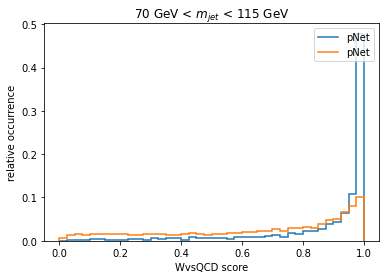

In [93]:
(out["sig_WWjj_4f_EWK"]["pNet"]/out["sig_WWjj_4f_EWK"]["pNet"].sum()).plot()
h_p1 = out["bkg_WJets_70To100"]["pNet"]
h_p2 = out["bkg_WJets_100To200"]["pNet"]
h_p3 = out["bkg_WJets_200To400"]["pNet"]
h_p4 = out["bkg_WJets_400To600"]["pNet"]
h_p5 = out["bkg_WJets_600To800"]["pNet"]
h_p6 = out["bkg_WJets_800To1200"]["pNet"]
h_p7 = out["bkg_WJets_1200To2500"]["pNet"]
h_p8 = out["bkg_WJets_2500ToInf"]["pNet"]
h_p = ((h_p1*x1+h_p2*x2+h_p3*x3+h_p4*x4+h_p5*x5+h_p6*x6+h_p7*x7+h_p8*x8)/(x1+x2+x3+x4+x5+x6+x7+x8))
(h_p/h_p.sum()).plot()
plt.title("70 GeV < $m_{jet}$ < 115 GeV")
plt.xlabel("WvsQCD score")
plt.ylabel("relative occurrence")
plt.legend()